In [1]:
import os
import torch 
from typing import List
import pandas as pd
import numpy as np
import rasterio
from cloud_model import CloudModel
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as tv_transform

bands = ["B02", "B03", "B04", "B08"]

In [2]:
# загружаем подготовленный набор изображений и меток с путями
df = pd.read_csv('data/train_metadata_my.csv')
df.head()

,chip_id,location,datetime,cloudpath,year,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwp,2020,J:\CloudCover\data\data\train_features\adwp\B0...,J:\CloudCover\data\data\train_features\adwp\B0...,J:\CloudCover\data\data\train_features\adwp\B0...,J:\CloudCover\data\data\train_features\adwp\B0...,J:\CloudCover\data\data\train_labels\adwp.tif
1,adwu,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwu,2020,J:\CloudCover\data\data\train_features\adwu\B0...,J:\CloudCover\data\data\train_features\adwu\B0...,J:\CloudCover\data\data\train_features\adwu\B0...,J:\CloudCover\data\data\train_features\adwu\B0...,J:\CloudCover\data\data\train_labels\adwu.tif
2,adwz,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwz,2020,J:\CloudCover\data\data\train_features\adwz\B0...,J:\CloudCover\data\data\train_features\adwz\B0...,J:\CloudCover\data\data\train_features\adwz\B0...,J:\CloudCover\data\data\train_features\adwz\B0...,J:\CloudCover\data\data\train_labels\adwz.tif
3,adxp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adxp,2020,J:\CloudCover\data\data\train_features\adxp\B0...,J:\CloudCover\data\data\train_features\adxp\B0...,J:\CloudCover\data\data\train_features\adxp\B0...,J:\CloudCover\data\data\train_features\adxp\B0...,J:\CloudCover\data\data\train_labels\adxp.tif
4,aeaj,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/aeaj,2020,J:\CloudCover\data\data\train_features\aeaj\B0...,J:\CloudCover\data\data\train_features\aeaj\B0...,J:\CloudCover\data\data\train_features\aeaj\B0...,J:\CloudCover\data\data\train_features\aeaj\B0...,J:\CloudCover\data\data\train_labels\aeaj.tif


In [7]:
def load_chip(row, transforms = None):
    data={
        "chip_id":row.iloc[0],
        "image":None,
        "label":None
    }
    band_arrs = []
    for band in row[5:9]:
        with rasterio.open(band) as b:
            band_arr = b.read(1).astype("float32")
        band_arrs.append(band_arr)
    
    # для меток
    with rasterio.open(row[9]) as lp:
        y_arr = lp.read(1).astype("float32")

    # NDVI = (iRed - Red)/(iRed + Red)индекс растительности
    data['ndvi'] = (band_arrs[3] - band_arrs[2])/(band_arrs[3] + band_arrs[2] + 1)
    
    # NDSI = (Green - iRed)/(Green + iRed)индекс снега
    data['ndsi'] = (band_arrs[1] - band_arrs[3])/(band_arrs[1] + band_arrs[3] + 1)

    # NDSI = (Green - iRed)/(Green + iRed)индекс снега
    data['new1'] = band_arrs[0] + band_arrs[1] + band_arrs[3]

    x_arr = np.stack(band_arrs, axis=-1)
        
    # Apply data augmentations, if provided
    if transforms:
        t = transforms(image = x_arr, mask = y_arr)
        x_arr = t["image"]
        y_arr = t["mask"] 

    data["image"] = np.transpose(x_arr, [2, 0, 1])
    data["label"] = y_arr
    
    return data

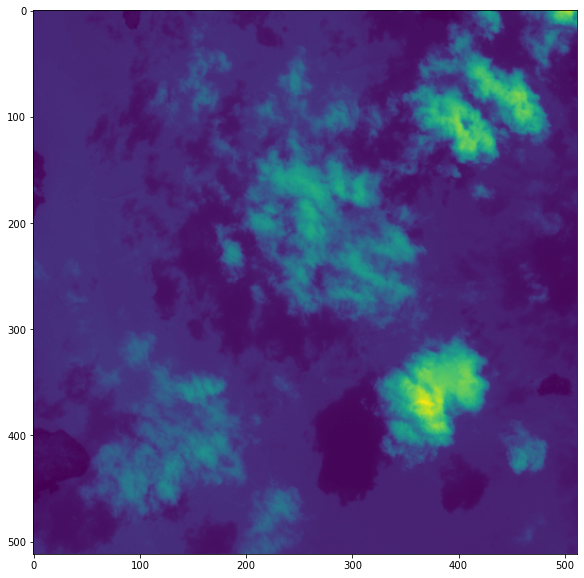

In [8]:
chip = load_chip(df.iloc[0])
plt.gcf().set_size_inches((10,10))
plt.imshow(chip['image'][0])

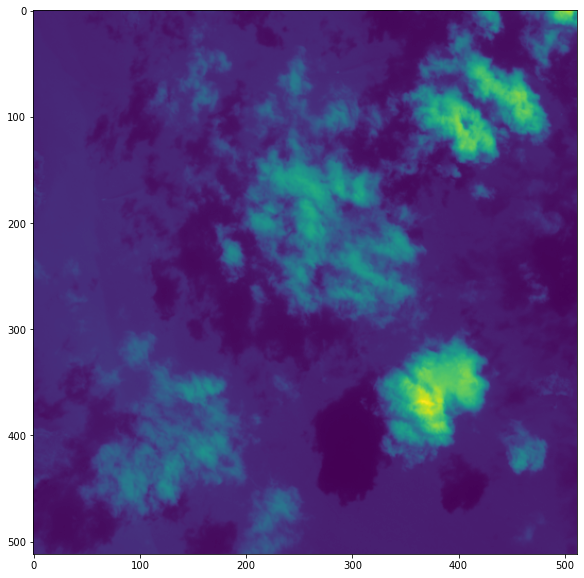

In [9]:
chip = load_chip(df.iloc[0])
plt.gcf().set_size_inches((10,10))
plt.imshow(chip['new1'])

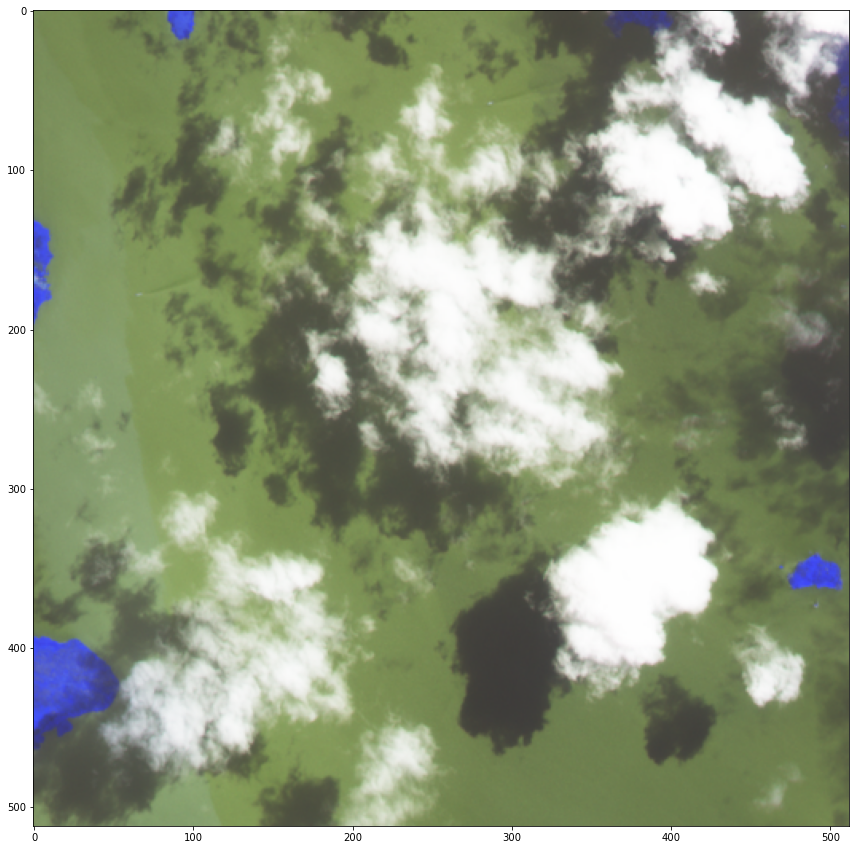

In [11]:
# https://rammb.cira.colostate.edu/wmovl/vrl/tutorials/satmanu-eumetsat/satmanu/basic/channels/Combo.htm
import xarray
import numpy as np
from PIL import Image
import xrspatial.multispectral as ms

def get_xarray(filepath):
    """Put images in xarray.DataArray format"""
    im_arr = np.array(Image.open(filepath))
    return xarray.DataArray(im_arr, dims=["y", "x"])

chip = load_chip(df.iloc[0])
red = xarray.DataArray(chip['image'][0], dims=["y", "x"])
green = xarray.DataArray(chip['image'][1], dims=["y", "x"])
blue = xarray.DataArray(chip['image'][3], dims=["y", "x"])
ms1 = ms.true_color(r=red, g=green, b=blue)
plt.gcf().set_size_inches(15,15)
plt.imshow(ms1)

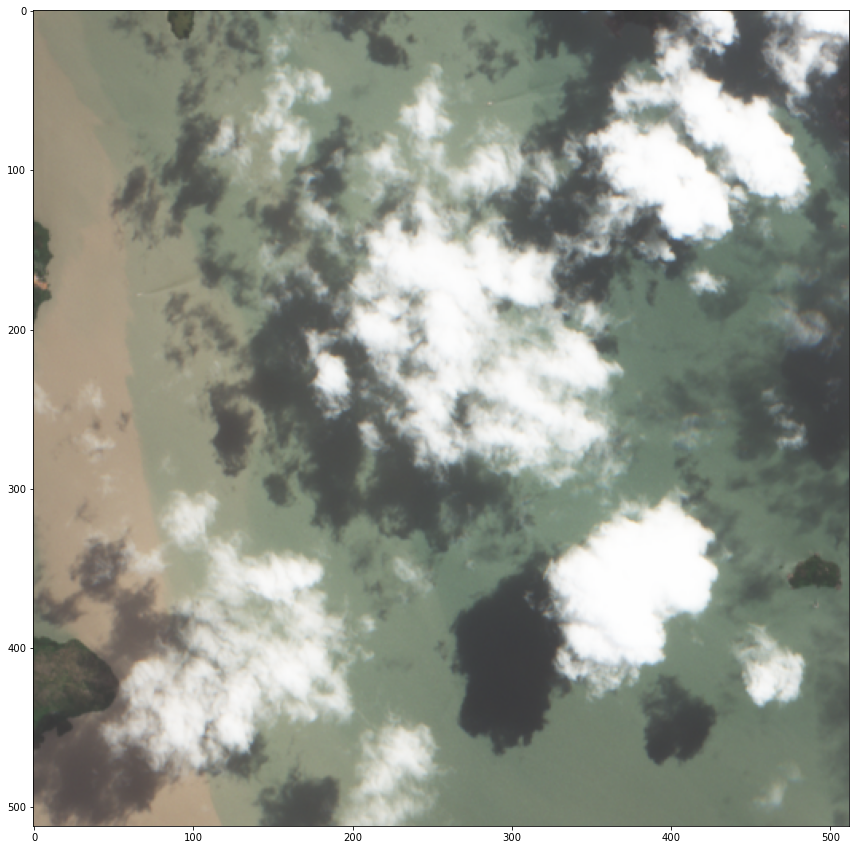

In [37]:
chip = load_chip(df.iloc[0])
red = xarray.DataArray(chip['image'][2], dims=["y", "x"])
green = xarray.DataArray(chip['image'][1], dims=["y", "x"])
blue = xarray.DataArray(chip['image'][0], dims=["y", "x"])
ms1 = ms.true_color(r=red, g=green, b=blue)
plt.gcf().set_size_inches(15,15)
plt.imshow(ms1)

C:\Users\Gorun\anaconda3\envs\cloud_env\lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


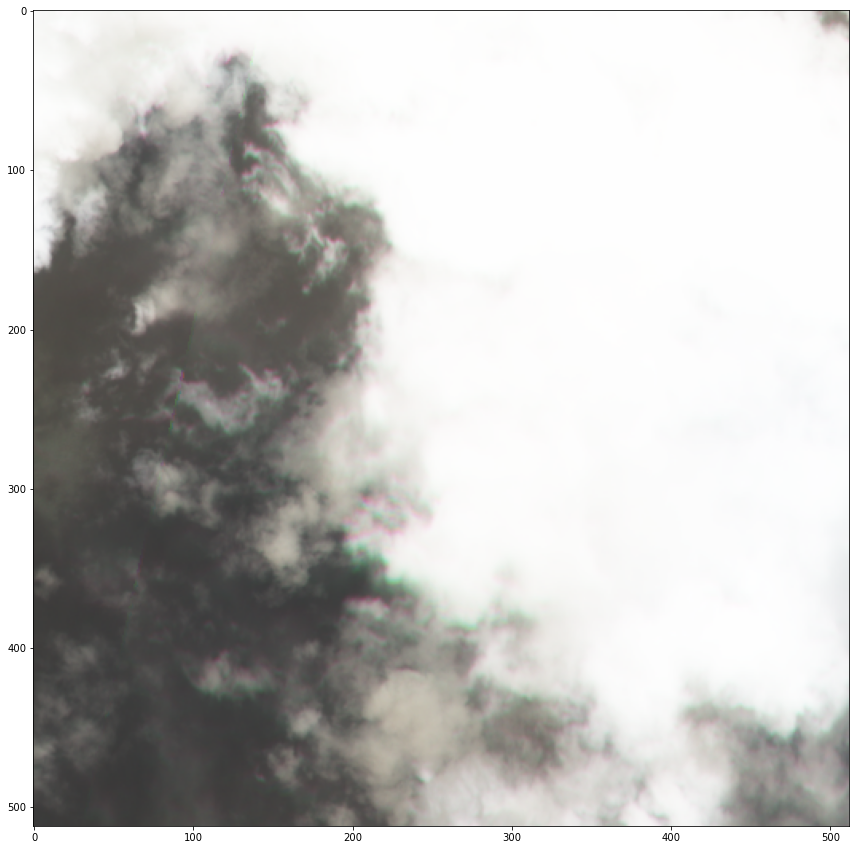

In [15]:
chip = load_chip(df.iloc[2])
red = xarray.DataArray(chip['image'][0], dims=["y", "x"])
green = xarray.DataArray(chip['image'][1], dims=["y", "x"])
blue = xarray.DataArray(chip['image'][3], dims=["y", "x"])
ms1 = ms.true_color(r=red, g=green, b=blue)
plt.gcf().set_size_inches(15,15)
plt.imshow(ms1)

In [20]:
import albumentations as A 

a1 = A.ToGray()

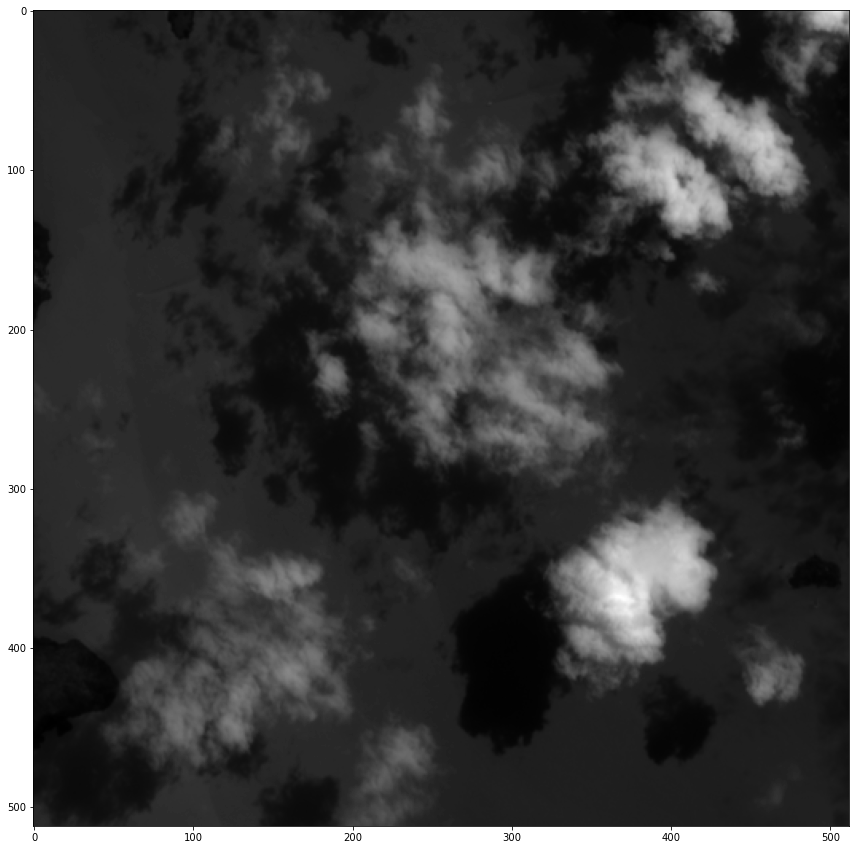

In [36]:
chip = load_chip(df.iloc[0])

# red = xarray.DataArray(chip['image'][0], dims=["y", "x"])
# green = xarray.DataArray(chip['image'][1], dims=["y", "x"])
# blue = xarray.DataArray(chip['image'][3], dims=["y", "x"])
# ms1 = ms.true_color(r=red, g=green, b=blue)
# 0.2126*red + 0.7152*green + 0.0722*blue
red = chip['image'][2]
green = chip['image'][1]
blue = chip['image'][0]

gray = 0.2126*red + 0.7152*green + 0.0722*blue
plt.gcf().set_size_inches(15,15)
plt.imshow(gray, cmap='gray')